# Plotting cluster locations on histology slices

This example walks through various ways to display the 3D location of clusters on histology slices

## Data Preparation

For all examples below the xyz coordinates of each point and an array of values must be provided. Here we load in the spikesorting data for an example probe insertion and set the xyz coordinates to the coordinates of the clusters and the array of values to the firing rate.

In [1]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from iblatlas.atlas import AllenAtlas
import numpy as np

one = ONE()
ba = AllenAtlas()
pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'
sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

# Extract xyz coords from clusters dict
# Here we will set all ap values to a chosen value for visualisation purposes
xyz = np.c_[clusters['x'], np.ones_like(clusters['x']) * 400 / 1e6, clusters['z']]
values = clusters['firing_rate']

/opt/hostedtoolcache/Python/3.12.9/x64/lib/python3.12/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-05-06"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


/opt/hostedtoolcache/Python/3.12.9/x64/lib/python3.12/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-05-06"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


## Example 1: Aggregation methods

The values of points that lie within the same voxel within the volume can be aggregated together in different ways by changing the `aggr` argument. Below shows an example where values in each voxel have been aggregated according to the average firing rate of the clusters (left) and according to the count of clusters in each voxel (right)

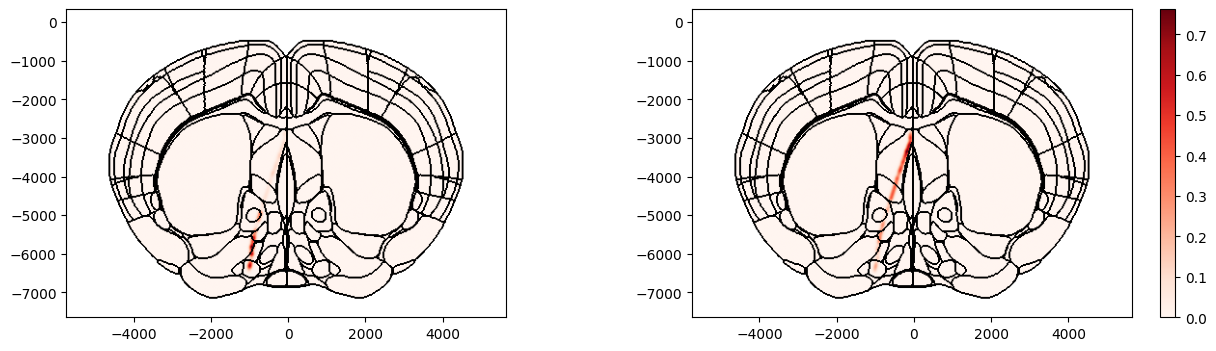

In [2]:
from iblatlas.plots import plot_points_on_slice
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16,4))

# Plot points on the coronal slice at ap=400um overlaid overlaid on brain region boundaries using Allen mapping 
# and a 3D gaussian kernel with fwhm=100um is applied

# Values in the same voxel are aggregated by the mean
fig, ax = plot_points_on_slice(xyz, values=values, coord=400, slice='coronal', mapping='Allen', background='boundary', 
                               cmap='Reds', aggr='mean', fwhm=100, brain_atlas=ba, ax=axs[0])

# Values in the same voxel are aggregated by the count
# N.B. can also pass values=None in this case as they are not used in the computation
fig, ax, cbar = plot_points_on_slice(xyz, values=values, coord=400, slice='coronal', mapping='Allen', background='boundary', 
                               cmap='Reds', aggr='count', fwhm=100, brain_atlas=ba, ax=axs[1], show_cbar=True)

The different options for aggregation are listed in the docstring of the function

In [3]:
help(plot_points_on_slice)

Help on function plot_points_on_slice in module iblatlas.plots:

plot_points_on_slice(xyz, values=None, coord=-1000, slice='coronal', mapping='Allen', background='boundary', cmap='Reds', clevels=None, show_cbar=False, aggr='mean', fwhm=100, brain_atlas=None, ax=None)
    Plot xyz points on slice. Points that lie in the same voxel within slice are aggregated according to method specified.
    A 3D Gaussian smoothing kernel with distance specified by fwhm is applied to images.

    :param xyz: 3 column array of xyz coordinates of points in metres
    :param values: array of values per xyz coordinates, if no values are given the sum of xyz points in each voxel is
    returned
    :param coord: coordinate of slice in um (not needed when slice='top')
    :param slice: orientation of slice, options are 'coronal', 'sagittal', 'horizontal', 'top' (top view of brain)
    :param mapping: atlas mapping to use, options are 'Allen', 'Beryl' or 'Cosmos'
    :param background: background slice to ove

## Example 2: Applying gaussian kernels with varying FWHM

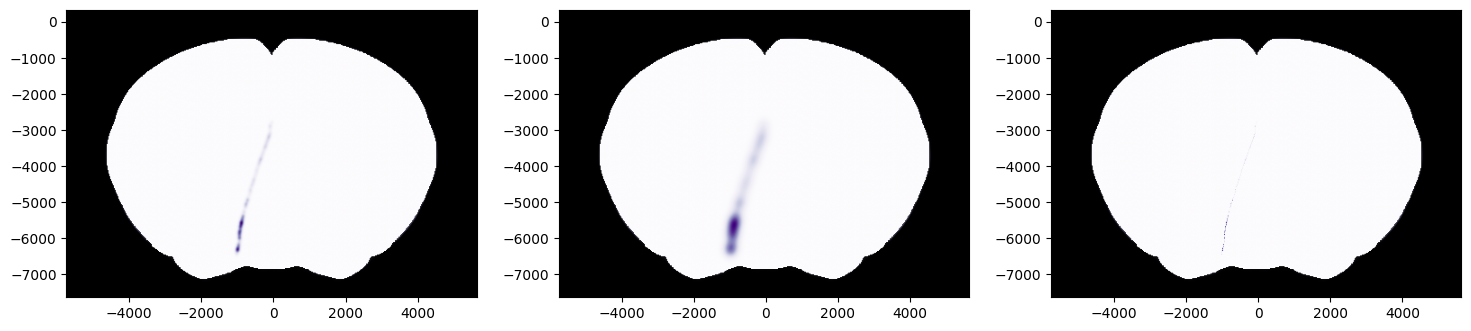

In [4]:
# Plot points on the coronal slice at ap=400um overlaid overlaid on Allen dwi image using Cosmos mapping with
# values aggregated by max

figs, axs = plt.subplots(1, 3, figsize=(18,4))

# FWHM of 100 um
fig, ax = plot_points_on_slice(xyz, values=values, coord=400, slice='coronal', background='image', 
                               cmap='Purples', aggr='max', fwhm=100, brain_atlas=ba, ax=axs[0])

# FWHM of 300 um
fig, ax = plot_points_on_slice(xyz, values=values, coord=400, slice='coronal', background='image', 
                               cmap='Purples', aggr='max', fwhm=300, brain_atlas=ba, ax=axs[1])

# FWHM of 0 um
# if fwhm=0 no gaussian kernal applied
fig, ax = plot_points_on_slice(xyz, values=values, coord=400, slice='coronal', background='image', 
                               cmap='Purples', aggr='max', fwhm=0, brain_atlas=ba, ax=axs[2])

## Example 3: Precomputing Volume

Convolving the 3D volume with the gaussian kernal can take some time to compute, particularly when using a large fwhm value. When exploring the same volume at different coordinates and using different slices it is recommended to precompute the volume and then plot the slices. Below shows an example of how to do this.

In [5]:
from iblatlas.plots import compute_volume_from_points, plot_volume_on_slice

# Extract xyz coords from clusters dict
xyz = np.c_[clusters['x'], clusters['y'], clusters['z']]
values = clusters['amp_max']

# Compute volume
volume = compute_volume_from_points(xyz, values=values, aggr='mean', fwhm=250, ba=ba)

Text(0.5, 1.0, 'ap = 500um')

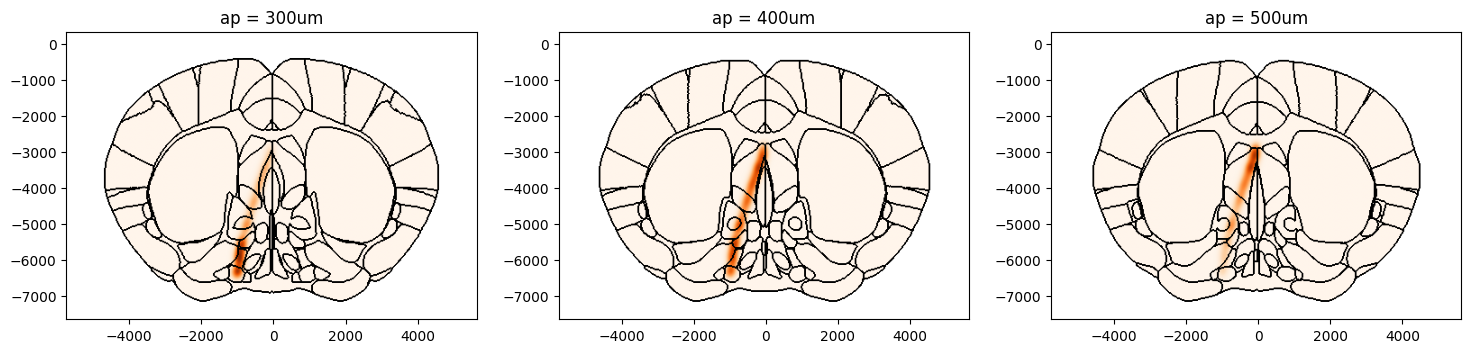

In [6]:
# Plot points on the coronal slices on brain region boundaries using Beryl maping
figs, axs = plt.subplots(1, 3, figsize=(18,4))
fig, ax = plot_volume_on_slice(volume, coord=300, slice='coronal', mapping='Beryl', background='boundary', 
                               cmap='Oranges', brain_atlas=ba, ax=axs[0])
ax.set_title('ap = 300um')
fig, ax = plot_volume_on_slice(volume, coord=400, slice='coronal', mapping='Beryl', background='boundary', 
                               cmap='Oranges', brain_atlas=ba, ax=axs[1])
ax.set_title('ap = 400um')
fig, ax = plot_volume_on_slice(volume, coord=500, slice='coronal', mapping='Beryl', background='boundary', 
                               cmap='Oranges', brain_atlas=ba,ax=axs[2])
ax.set_title('ap = 500um')

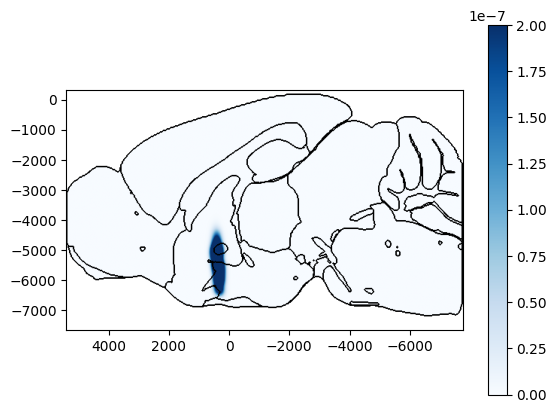

In [7]:
# Plot points on the saggital slice at ap=-800um overlaid on brain region boundaries using Cosmos mapping
fig, ax, cbar = plot_volume_on_slice(volume, coord=-800, slice='sagittal', mapping='Cosmos', background='boundary', 
                               cmap='Blues', brain_atlas=ba, clevels=[0, 2e-7], show_cbar=True)

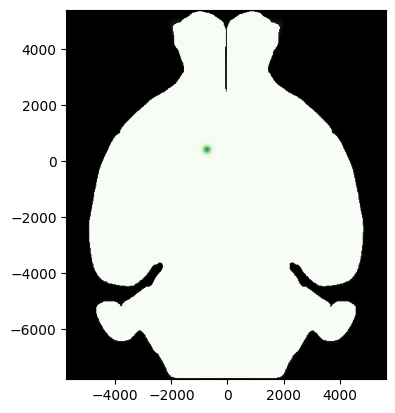

In [8]:
# Plot points on the horizontal slice at dv=-5000um overlaid on allen dwi image
fig, ax = plot_volume_on_slice(volume, coord=-5000, slice='horizontal', background='image', cmap='Greens', brain_atlas=ba)